# Aclima Data Science Challenge

*Dmitri Kalashnikov | 2019*

### An Analysis of California NO2 vulnerability using census tract data

- Nitrogen Dioxide (NO2) is an air pollutant composed of nitrogen and oxygen. Although NO2 is a naturally occurring compound, harmful emissions occur regularly from human-caused sources. According to the EPA, notable pollution sources include vehicles, power plants and industrial emissions, among others. California is the most populous state in the nation with nearly 40 million residents (as of 2018). The goal of this project is to infer which census tracts within California are likely to be characterized by high NO2 concentrations, and why this might be the case. Due to the large population found within the state, accurate quantification and prediction of air pollution carries added significance for public health concerns. 

### Summary bullet points:

- I conducted analysis using Python.
- Major packages utilized include Pandas, GeoPandas, NumPy, Matplotlib, Seaborn, and Statsmodels.
- NO2 data was subset to only Sensor-1 observations, or 88.7% of data.
- A total of 123 NO2 monitoring sites were analyzed, and 114 used for predictive modeling.
- Seasonal and diurnal cycles are apparent in the NO2 data.
- High NO2 values are concentrated in San Francisco and Los Angeles areas.
- An alternative way of joining NO2 and census data was explored, in addition to nearest join.
- Tox. Release is most positively correlated variable with NO2 levels.
- White (%) is most negatively correlated variable with NO2 levels.
- A Multiple Linear Regression (OLS) model was built with 4 selected predictor variables.
    - Variables selected: Ozone, Diesel PM, Tox. Release, White %
    - Adjusted R-squared of 0.905
    - All predictor variables statistically significant (p-value < 0.05), with acceptable VIFs
    - Ozone, Diesel PM and Tox. Release coefficients are positive, White % is negative
- Finally, I discuss other modeling approaches that could be applied to this data.

# 1. Importing Packages and NO2 Data

In [49]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import seaborn as sns
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopy.distance as gd
import statsmodels.api as sm
from statsmodels.stats import outliers_influence as soi
from statsmodels.graphics import regressionplots as rp
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore') # suppresses runtime warnings in output

# Reading in .csv as Pandas dataframe, and managing file paths
pwd = os.getcwd()
indir = "C:/users/dmitri4/Desktop"
os.chdir(indir)
df = pd.read_csv('epa_no2_cal_df_hourly.csv')
os.chdir(pwd)

# 2. NO2 Data Cleaning

In [2]:
# Checking for columns which have identical values in all fields, printing names to console
for idx in range(len(df.columns)):
    column = df.iloc[:,idx]
    if column.nunique() == 1:
        print(df.columns[idx])
        
# 5 columns can be dropped as they don't provide any info --> several GB of space freed
df = df.drop(columns=['state_code','state_name'])
df = df.drop(columns=['parameter_code','parameter_name','units_of_measure'])

state_code
parameter_code
parameter_name
units_of_measure
state_name


In [3]:
# Understanding the types of data in NO2 file
df['poc'].nunique() # 4 unique sensor types (1,2,3,5)
df['date_local'].nunique() # 4,018 unique dates (11 years)
df['time_local'].nunique() # 24 unique obs times (hours)
df['county_code'].nunique() # 37 counties (CA has 58 counties total)
df['datum'].nunique() # 4 different datums are used

# Figuring out number of unique sites (unique combinations of site + county)
print('Number of unique NO2 measuring sites:')
print(len(df.groupby(['site_num','county_code'])))

# Dropping more columns that won't be needed
df = df.drop(columns=['date_gmt', 'time_gmt', 'datum']) # won't worry about datums for this application
df = df.drop(columns=['mdl', 'county_name'])

# Total of 8,876,653 observations in NO2 dataset
# Checking obs count by sensor type (1,2,3 and 5)
print('Number of type-1 sensor observations:')
print(df[df['poc'] == 1].count()[7]) # 7,876,108 (88.7%)
print('This corresponds to 88.7% of all NO2 hourly observations in dataset.')
sensor2 = df[df['poc'] == 2].count() # 804,044 (9.1%)
sensor3 = df[df['poc'] == 3].count() # 110,790 (1.2%)
sensor4 = df[df['poc'] == 5].count() # 85,711 (1.0%)

# Subsetting to just type-1 sensor obs
only_sensor1 = df[df['poc'] == 1]
only_sensor1 = only_sensor1.drop(columns=['poc']) # no longer need the 'poc' column

# This has retained 123 of 136 NO2 measuring sites
print('Number of NO2 sites retained:')
print(len(only_sensor1.groupby(['site_num','county_code'])))

Number of unique NO2 measuring sites:
136
Number of type-1 sensor observations:
7876108
This corresponds to 88.7% of all NO2 hourly observations in dataset.
Number of NO2 sites retained:
123


- I have chosen to only explore sites that have 'poc' == 1 in order to control for different types of instruments used to measure NO2. I am comfortable doing this because we still retain 88.7% of observations in the .csv file (2007-2017). It seems most AQ measuring sites in California rely on this type of sensor for NO2 measurement. This retains 123 unique sites in the dataset.

In [4]:
# Checking that all observations are unique
counties = only_sensor1['county_code']
sites = only_sensor1['site_num']
dates = only_sensor1['date_local']
times = only_sensor1['time_local']
new_df = pd.concat([counties, sites, dates, times], axis=1)
dups = new_df.duplicated()
size = np.size(np.where(dups == True)) # no duplicates --> 7,876,108 unique combinations
# no duplicate observations/rows --> good to proceed!

# Checking number of hourly observations, by site (2007-2017)
test_df = pd.concat([sites, counties], axis=1)
no_dups = test_df.drop_duplicates() # 123 unique sites
df0 = test_df.groupby(['site_num','county_code']).size().reset_index().rename(columns={0:'obs_count'})
obs_per_site = df0.obs_count
print('Maximum obs count:')
print(np.max(obs_per_site))
print('Minimum obs count:')
print(np.min(obs_per_site))

# Will now call this dataframe 'no2_df'
no2_df = df
del df

Maximum obs count:
93077
Minimum obs count:
5302


- There is a wide range of observation counts among the 123 sites, with a maximum of 93,077 hourly obs in the 11-year span and a minimum of 5,302 obs.

- Since this project is primarily concerned with spatial analysis, I will proceed by simply averaging all hourly observations at each location regardless of obs count. If I had more time, I would explore being more rigorous about this. I would probably control for what times (hour of day) the obs are coming from, and during what months of the year. Some of those locations with low obs counts might have disproportionately high obs counts during the summer, or during the day, etc thus skewing the average values. 

# 3. NO2 Data Exploration and Visualization

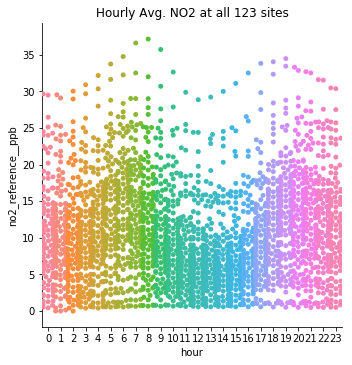

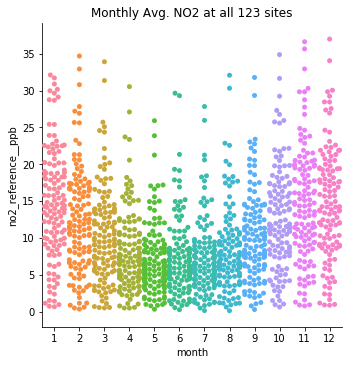

In [5]:
# Understanding the seasonal and diurnal cycles of NO2 readings
only_sensor1['month'] = pd.to_datetime(only_sensor1['date_local']).dt.month # extract months
only_sensor1['hour'] = pd.to_datetime(only_sensor1['time_local']).dt.hour # extract hours
hourly = only_sensor1.groupby(['site_num','county_code','hour']).mean().reset_index()
monthly = only_sensor1.groupby(['site_num','county_code','month']).mean().reset_index()

# Categorical plots of diurnal and seasonal cycles
# Using Seaborn
sns.catplot(x="hour", y="no2_reference__ppb", kind="swarm", data=hourly)
plt.title('Hourly Avg. NO2 at all 123 sites')
sns.catplot(x="month", y="no2_reference__ppb", kind="swarm", data=monthly)
plt.title('Monthly Avg. NO2 at all 123 sites')
plt.show()

- The above plots show the diurnal and seasonal cycles at all 123 measuring locations, averaged by hour at each location in the first plot, and averaged by month at each location in the 2nd plot. 

- NO2 concentrations have both seasonal and diurnal cycles. Concentrations peak around rush hour, both morning and evening. This is most likely due to heavy traffic and resulting emissions during those times. There is also a seasonal cycle, with lower NO2 values during the summer. Concentrations peak during the cool season especially in November and December. Not sure why this is, but maybe due to low-level atmospheric inversions which tend to form in the western US during the winter. This traps air pollution in the lowest layers of the atmosphere and can lead to especially bad air quality in valley locations.

- It would be interesting to apply this temporal data in a modeling effort, perhaps in a hierarchical/Bayesian approach that also takes into account the spatial variation in the NO2 data (shown in the remainder of this presentation).

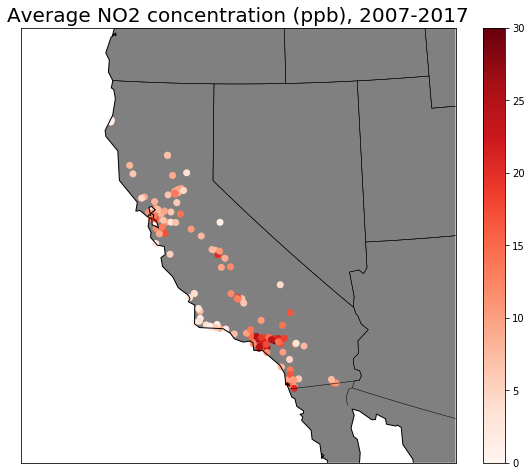

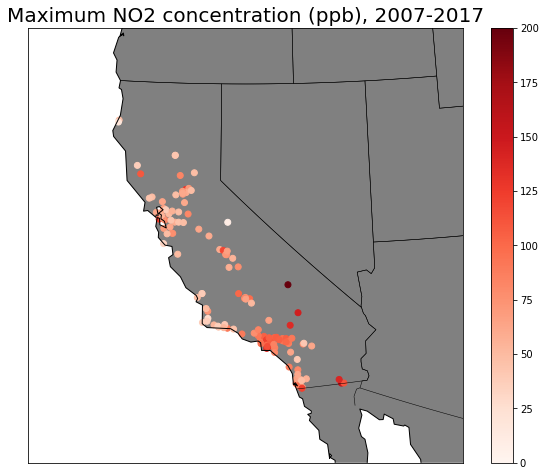

In [6]:
# Calculating and plotting mean & max NO2 values at all sites
site_means = no2_df.groupby(['site_num', 'county_code']).mean()
mean_vals = site_means['no2_reference__ppb'] # NO2 means at all 123 sites, from all hourly obs

site_max = no2_df.groupby(['site_num', 'county_code']).max() 
peak_vals = site_max['no2_reference__ppb'] # Maximum NO2 recorded at all 123 sites, from all hourly obs

# Using Matplotlib with Basemap toolkit
plt.figure(figsize=(10, 8))
m = Basemap(projection='lcc', area_thresh=10000, resolution='l',
            width=1.5E6, height=1.5E6,
            lat_0=37, lon_0=-119)
m.fillcontinents(color='gray',lake_color='white',alpha=1,zorder=0)
m.drawstates(linewidth=0.5,linestyle='solid',color='k')
m.drawcountries(linewidth=0.5,linestyle='solid',color='k')
m.drawcoastlines(color='black')
lon = list(site_means.longitude)
lat = list(site_means.latitude)
means = list(site_means.no2_reference__ppb)
m.scatter(lon, lat, latlon=True,
          c=means, cmap='Reds', alpha=1)
plt.colorbar()
plt.title('Average NO2 concentration (ppb), 2007-2017', size=20)
plt.clim(0,30)
plt.show()

plt.figure(figsize=(10, 8))
m = Basemap(projection='lcc', area_thresh=10000, resolution='l',
            width=1.5E6, height=1.5E6,
            lat_0=37, lon_0=-119)
m.fillcontinents(color='gray',lake_color='white',alpha=1,zorder=0)
m.drawstates(linewidth=0.5,linestyle='solid',color='k')
m.drawcountries(linewidth=0.5,linestyle='solid',color='k')
m.drawcoastlines(color='black')
lon = list(site_means.longitude)
lat = list(site_means.latitude)
means = list(site_max.no2_reference__ppb)
m.scatter(lon, lat, latlon=True,
          c=means, cmap='Reds', alpha=1)
plt.colorbar()
plt.title('Maximum NO2 concentration (ppb), 2007-2017', size=20)
plt.clim(0,200)
plt.show()

- A couple things jump out - the highest average NO2 concentration is at a site near Ontario Int'l Airport (1st plot). This location seems to have all the necessary ingredients - planes taking off and landing, heavy truck traffic, industrial operations, etc. It's also in a basin location where air tends to stagnate. In fact, this location was profiled by the LA Times back in 2015 for having the worst air quality in the southland:
    https://www.latimes.com/science/la-me-freeway-soot-20150909-story.html

- The highest one-hour concentration in the entire dataset was measured in Trona, a small town in the desert (2nd plot). One of their hourly measurements registered 223 ppb! In fact, the top 18 highest hourly measurements in the dataset are from this sensor in Trona, and no other California site has measured a reading above 157 ppb. This area has been profiled for being especially polluted due to past mineral extraction and processing. Their highest one-hour concentration is the dark maroon dot in the eastern part of the state.

- Overall, there seems to be spatial clustering around the Los Angeles and San Francisco areas, especially in the mean values. Maximum values are particularly high in southern California, showing that they are especially prone to extreme air pollution episodes. 

# 4. Importing Census Data & Creating GeoDataFrames

In [7]:
# Importing the Excel file using Pandas, managing file paths
pwd = os.getcwd()
indir = "C:/users/dmitri4/Desktop"
os.chdir(indir)
df1 = pd.read_excel('ces3results.xlsx', sheet_name='CES 3.0 (2018 Update)')
# for 'Demographic profile', did some cleaning in Excel before importing -->
# merged header from two lines to one line
df2 = pd.read_excel('ces3results.xlsx', sheet_name='Demographic profile')
os.chdir(pwd)

# Joined the CES3.0 and Demographic profile Excel sheets into one dataframe, using 'Census_Tract'
ces3_df = pd.merge(df1, df2, on = 'Census_Tract')

# Using GeoPandas 

# Creating GeoDataFrame for NO2 data --> this assigns point geometry representing lat/lon
# Using Shapely's 'Point' function
geometry = [Point(xy) for xy in zip(site_means.longitude, site_means.latitude)]
crs = {'init': 'epsg:2263'} #http://www.spatialreference.org/ref/epsg/2263/
no2_gdf = GeoDataFrame(site_means, crs=crs, geometry=geometry)

# Creating GeoDataFrame for Census Tract data --> this assigns point geometry representing lat/lon of tract centroids
geometry = [Point(xy) for xy in zip(ces3_df.Longitude, ces3_df.Latitude)]
crs = {'init': 'epsg:2263'} #http://www.spatialreference.org/ref/epsg/2263/
demo_gdf = GeoDataFrame(ces3_df, crs=crs, geometry=geometry)

del ces3_df

# 5. Joining the NO2 and Census Datasets

In [8]:
# =====================================================================================================
# This code cell is a bit of a detour - this is me experimenting with a different way
# of assigning NO2 information to census tracts, before I proceed with given instructions :)
# =====================================================================================================

# One option -> first find the minimum distance to an NO2 observing site
# from all 8,035 census tract centroids
minimal_distances = []
for ii in zip(demo_gdf.Latitude, demo_gdf.Longitude): # lat/lon of census tract centroids
    census_tract = tuple(ii)
    sensors = []
    for jj in zip(no2_gdf.latitude, no2_gdf.longitude): # lat/lon of NO2 sensor locations
        sensor = tuple(jj)
        dist = gd.great_circle(census_tract, sensor).mi # using GeoPy's great circle distance functionality
        sensors.append(dist)
    min_dist = np.min(sensors)
    minimal_distances.append(min_dist)
# results show that some census tracts are more than 100 miles away
# from any NO2 sensor --> furthest is 155 miles (in northeast corner of CA)

# Next, subsetting to only census tracts which have NO2 sensor within 1 mile of centroid
minimal_distances = np.array(minimal_distances)
dist_1mi = np.where(minimal_distances <= 1)[0] # 350 census tracts out of 8,035 have NO2 sensor <1 mile away
gdf = demo_gdf.iloc[dist_1mi,:].reset_index() # subsetting the GeoDataFrame to those 350 tracts

# Next, taking mean of all NO2 sensor readings within given radius of each census tract centroid --> this will 
# account for more than one NO2 sensor in vicinity. In this case, I'm choosing
# approximately 2/69th of degree or about 2 miles.
tracts = np.empty(350)
for i in range(350): # 350 census tracts
    poly = gdf.geometry.iloc[i].buffer(distance = 0.029) # setting radius distance to 2/69th of degree 
    vals = []
    for j in range(123): # 123 NO2 sensors
        point = no2_gdf.geometry.iloc[j]
        idx = int(poly.contains(point)) # using Shapely's point-in-polygon 'contains' method
        # appending and averaging any sensor readings within 2 miles
        if idx == 1: 
            value = no2_gdf.no2_reference__ppb.iloc[j]
            vals.append(value)
        else:
            continue
    tracts[i] = np.mean(vals)
    del vals

# Finally, appending the NO2 window averages to GeoDataFrame
tracts = pd.Series(tracts)
gdf = pd.concat([gdf,tracts], axis = 1)
gdf.rename(columns={0:'no2_mean'}, inplace=True)

- Pardon the detour above, I hope you found it interesting. Just trying other ways of assigning NO2 data to census tracts. The approach outlined above would aggregate NO2 information from multiple sensors into each census tract, assuming there are several nearby sensors to pull data from.

- I am resuming main project workflow below.

In [9]:
# =============================================================================
# Now joining NO2 & census tract data the prescribed way, per instructions
# =============================================================================

# Here, I will join NO2 sensor locations with closest census tract centroid

gdf1 = no2_gdf # 123 NO2 measuring sites
gdf2 = demo_gdf # GeoDataFrame of census tracts

# A function to calculate minimum distance between geographic points in two dataframes
def min_dist(point, gdf2):
    gdf2['Dist'] = gdf2.apply(lambda row : point.distance(row.geometry),axis=1) # calculates all point-wise pairs
    geoseries = gdf2.iloc[gdf2['Dist'].idxmin()] # gets the minimum distance
    return geoseries

# Applying the function to our two datasets
nearest_tract = [min_dist(gdf1.geometry.iloc[k], gdf2)[0] for k in range(123)] # for all 123 NO2 locations

# Appending the nearest census tract to NO2 sensor locations
nearest_tract = pd.Series(nearest_tract)
no2_gdf = no2_gdf.reset_index()
no2_gdf = pd.concat([no2_gdf,nearest_tract], axis = 1)
no2_gdf.rename(columns={0:'Census_Tract'}, inplace=True)

# Finally, joining the two datasets on closest census tract column
joined_gdf = pd.merge(demo_gdf, no2_gdf, on = 'Census_Tract')
gdf = joined_gdf
gdf.rename(columns = {'no2_reference__ppb':'no2 (ppb)'}, inplace=True) # a nicer name

# Dropping some columns which are duplicates/relics following merges
gdf = gdf.drop(columns=['latitude','longitude','poc','Dist','county_code']) 
# Another set of 'Latitude' and 'Longitude' columns has been retained

# 6. Census Data Cleaning

In [10]:
# Before I do correlation analysis, need to remove all the percentile columns
# Will be working with original data

# Using a regular expression to search column names for "Pctl", and creating index
pattern = re.compile("Pctl")
drop_idx = []
for k in range(70): # searching through 70 columns
    match = pattern.search(str(gdf.columns.values[k]))
    if match is not None:
        drop_idx.append(gdf.columns.values[k])

# Using newly created index to drop the 22 columns which have "Pctl" in name
gdf = gdf.drop(columns = drop_idx)

# Now, need to drop all of the aggregate scores since they pull from the other
# data fields already in the dataset
gdf = gdf.drop(columns=['CES 3.0 Score',' CES 3.0 Percentile','CES 3.0 \nPercentile Range'])
gdf = gdf.drop(columns=['Pollution Burden','Pollution Burden Score'])
gdf = gdf.drop(columns=['Pop. Char. ','Pop. Char. Score'])

# The 'Missing&NAData' sheet from the CES 3.0 dataset indicates that a number
# of fields have numerous missing values. This can be confirmed by looking at the data.
# As a result, I am choosing to drop the following columns before starting correlation analysis:
gdf = gdf.drop(columns=['Pesticides','Cleanup Sites','Groundwater Threats'])
gdf = gdf.drop(columns=['Haz. Waste','Imp. Water Bodies','Solid Waste'])

# Next, dropping 'Pop 11-64 years (%)' and 'Children < 10 (%)'
# since they are complements of the 'Elderly > 65 (%)' column
gdf = gdf.drop(columns=['Pop 11-64 years (%)','Children < 10 (%)'])

# Finally, dropping 'Longitude' since California's geography is skewed
# by 1) long N-S extent, and 2) the E-W curvature of the coastline south of the Bay
gdf = gdf.drop(columns=['Longitude'])

# Retaining 'Latitude', but dropping 'ZIP' since zip codes are highly correlated
# with latitude in California, increasing from south to north as assigned by USPS
gdf = gdf.drop(columns=['ZIP'])

# Dropping sites that have NA values
gdf = gdf.dropna() # this reduces dataset from 123 to 114 sites

# Giving some columns more informative names
gdf = gdf.rename(columns={'Education':'Low Education','Drinking Water':'Drinking Water Contam. Index'})
gdf = gdf.rename(columns={'Census_Tract':'Census_Tract_Number'})

# 7. Correlation Analysis

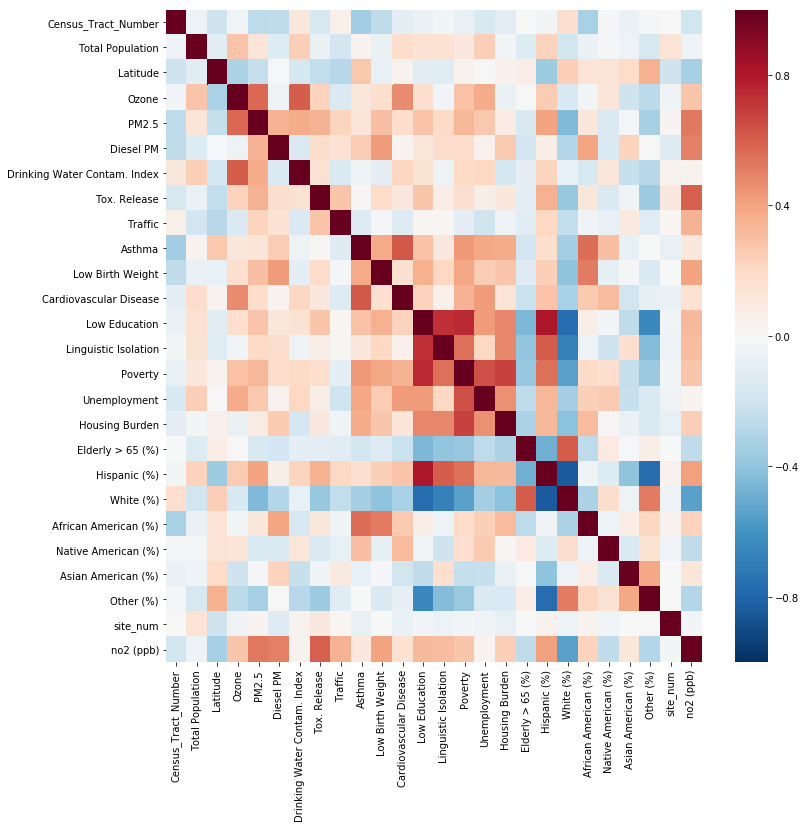

In [11]:
# Plotting pair-wise correlation coefficients between all variables
# Many different ways of doing this in Python, but I chose Seaborn heatmap
corr = gdf.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap = 'RdBu_r', vmin = -1, vmax = 1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

- The above correlation matrix shows a number of interesting pair-wise relationships. For example, the bottom row shows the correlation coefficients of NO2 with all retained census variables, with red colors indicating positive corels and blue values indicating negative corels. 

- Not surprisingly, the variables related to high pollution emissions and economic vulnerability are positively correlated with NO2 levels. Also, it's striking to see the contrast between positive corels for Hispanic % and negative corels for White % for these vulnerability indicators, especially since they are displayed adjacent in the matrix. 

In [12]:
# Pearson r-values for positively correlated variables with NO2
no2_corr = corr.iloc[:,-1]
no2_sorted = no2_corr.sort_values(ascending = False)
pos = no2_sorted[no2_sorted >= 0]
print('All positively correlated variables to NO2 levels, sorted:')
print('----------------------------------')
print(pos[1:-1])

All positively correlated variables to NO2 levels, sorted:
----------------------------------
Tox. Release                    0.595230
PM2.5                           0.529011
Diesel PM                       0.501972
Hispanic (%)                    0.406571
Low Birth Weight                0.398948
Traffic                         0.344793
Low Education                   0.324803
Linguistic Isolation            0.309155
Ozone                           0.279534
Poverty                         0.277038
Housing Burden                  0.242200
African American (%)            0.232025
Cardiovascular Disease          0.152978
Asian American (%)              0.121184
Asthma                          0.103795
Drinking Water Contam. Index    0.036065
Name: no2 (ppb), dtype: float64


- Tox. Release, PM2.5, and Diesel PM are the top-3 most correlated (positive) variables with NO2 levels. This is a good sanity check and what I expect to see, since all three variables are related to degraded air quality. 

In [13]:
# Pearson r-values for negatively correlated variables with NO2
neg = no2_sorted[no2_sorted < 0]
neg = neg.sort_values()
print('All negatively correlated variables to NO2 levels, sorted:')
print('-------------------------------')
print(neg)

All negatively correlated variables to NO2 levels, sorted:
-------------------------------
White (%)             -0.540341
Latitude              -0.328238
Other (%)             -0.290575
Native American (%)   -0.254617
Elderly > 65 (%)      -0.254367
Census_Tract_Number   -0.188497
Total Population      -0.059243
site_num              -0.025155
Name: no2 (ppb), dtype: float64


- Percentage of white residents is the most negatively correlated variable with NO2. Latitude is an interesting one as well, there is clearly a signal in California for higher NO2 levels further south in the state, at least for these stations. The earlier maps of average and peak NO2 values showed this as well. 

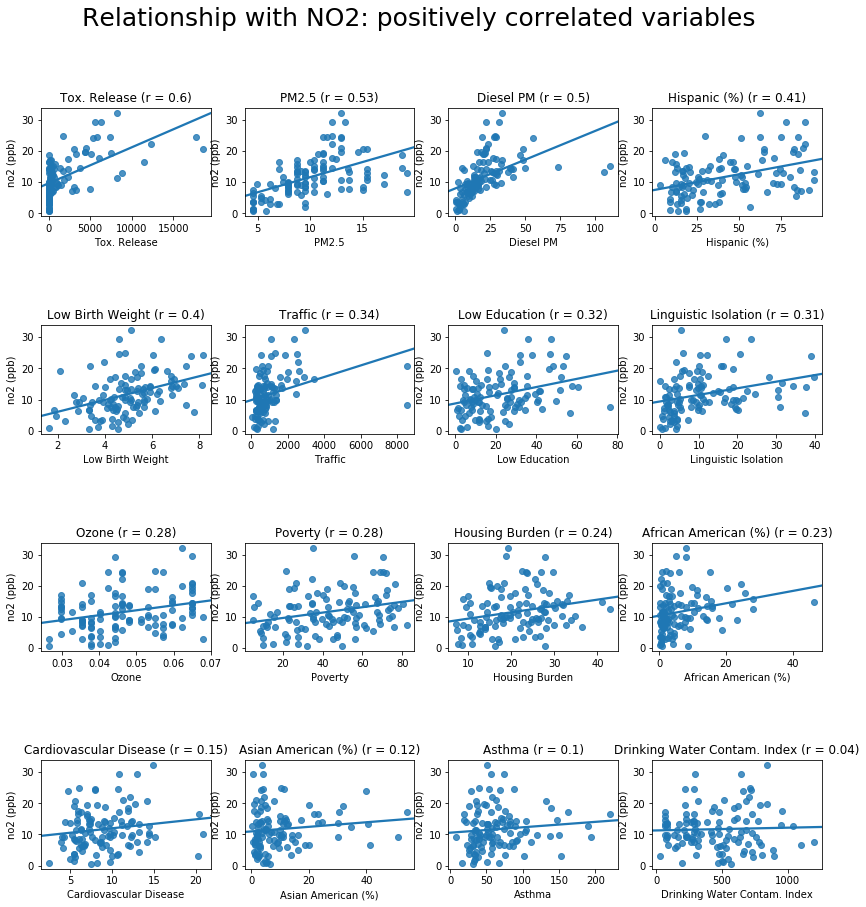

In [14]:
# Exploring pairwise relationships, first for the positively correlated variables
fig = plt.figure(figsize=(14, 14))
plt.suptitle('Relationship with NO2: positively correlated variables', size=25)
colnames_pos = pos.index[1:-1]
corels_pos = np.round(pos[1:-1],2)
for k in range(16):
    fig.add_subplot(4,4,k+1)
    sns.regplot(gdf[colnames_pos[k]], gdf['no2 (ppb)'], ci=None)
    plt.title('{} (r = {})'.format(colnames_pos[k], corels_pos[k]))
fig.subplots_adjust(hspace = 1)
plt.show()

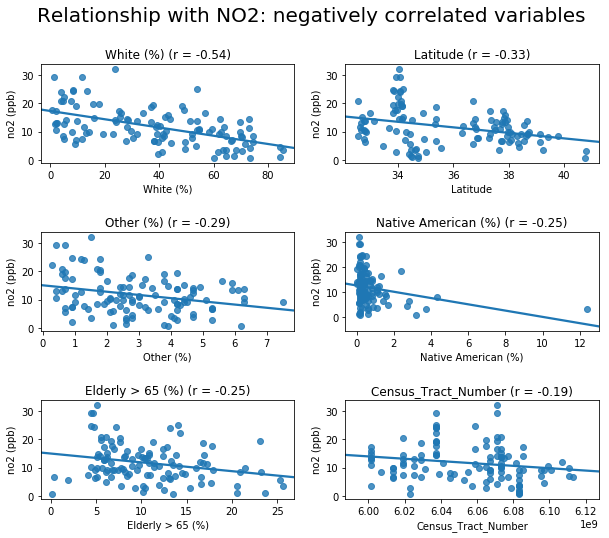

In [15]:
# Exploring pairwise relationships for negatively correlated variables
fig = plt.figure(figsize=(10, 8))
plt.suptitle('Relationship with NO2: negatively correlated variables', size=20)
colnames_neg = neg.index[:6]
corels_neg = np.round(neg[:6],2)
for k in range(6):
    fig.add_subplot(3,2,k+1)
    sns.regplot(gdf[colnames_neg[k]], gdf['no2 (ppb)'], ci=None)
    plt.title('{} (r = {})'.format(colnames_neg[k], corels_neg[k]))
fig.subplots_adjust(hspace = 0.7)
plt.show()

# 8. Distributions of Predictor Variables

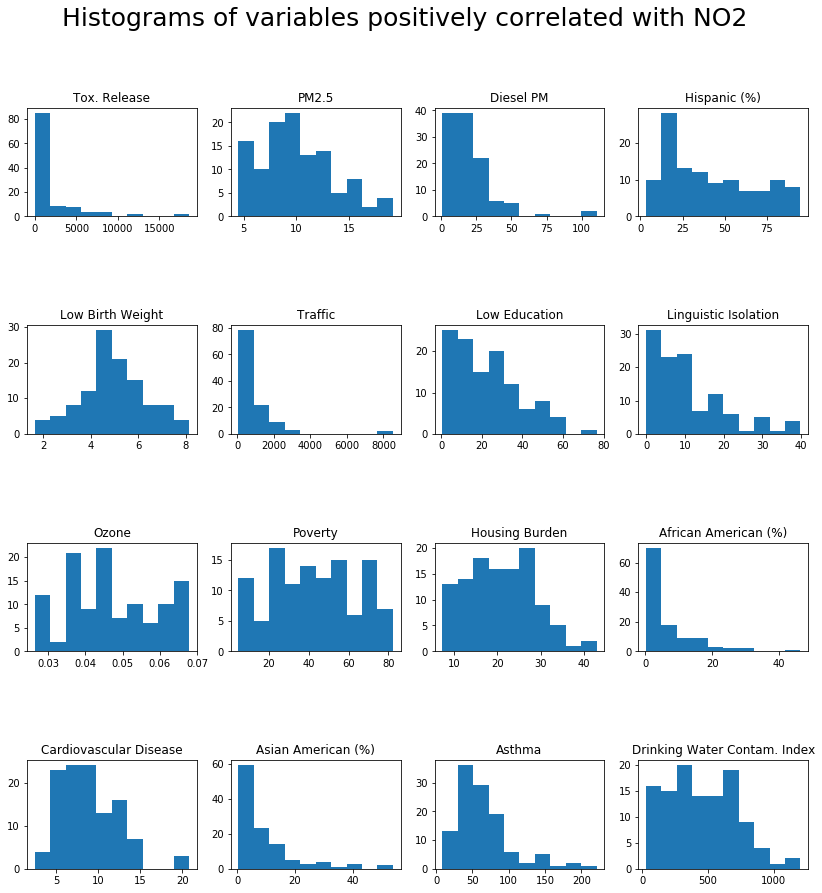

In [16]:
# Exploring distributions of positively correlated variables via histograms
# Some of the predictor variables are highly positively skewed
fig = plt.figure(figsize=(14, 14))
plt.suptitle('Histograms of variables positively correlated with NO2', size=25)
colnames_pos = pos.index[1:-1]
corels_pos = np.round(pos[1:-1],2)
for k in range(16):
    fig.add_subplot(4,4,k+1)
    plt.hist(gdf[colnames_pos[k]])
    plt.title('{}'.format(colnames_pos[k]))
fig.subplots_adjust(hspace = 1)
plt.show()

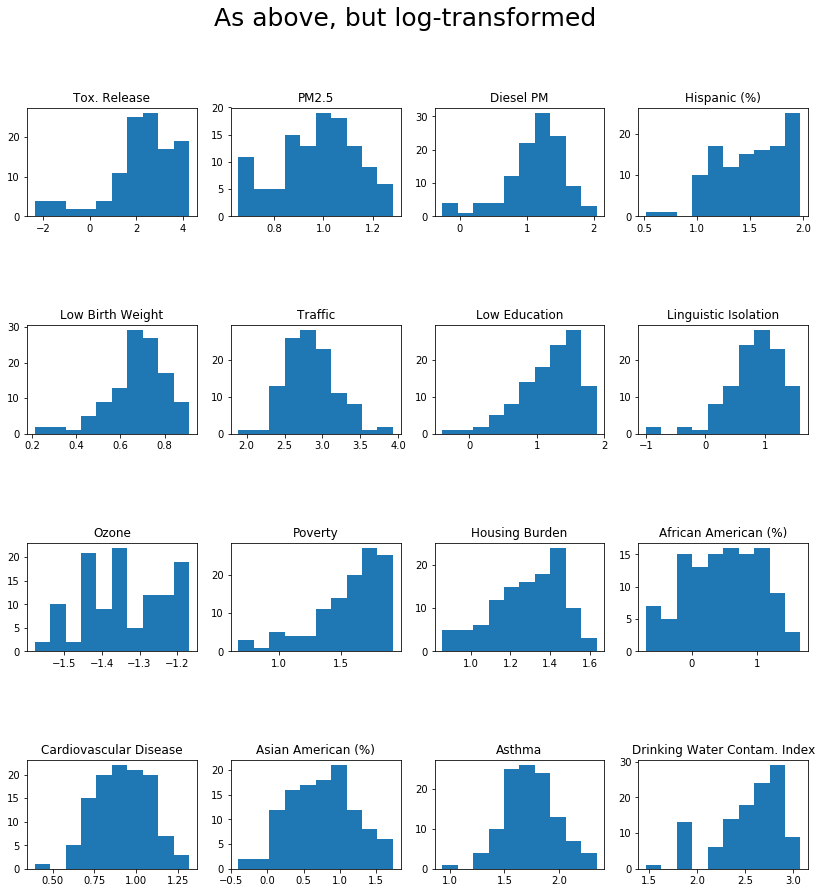

In [17]:
# Applying a log-transformation to see how the distributions change

# First, a quick and dirty way to handle a couple zero values --> setting to 0.1
gdf['Linguistic Isolation'][39] = 0.1
gdf['Linguistic Isolation'][105] = 0.1

fig = plt.figure(figsize=(14, 14))
plt.suptitle('As above, but log-transformed', size=25)
colnames_pos = pos.index[1:-1]
corels_pos = np.round(pos[1:-1],2)
for k in range(16):
    fig.add_subplot(4,4,k+1)
    plt.hist(np.log10(gdf[colnames_pos[k]]))
    plt.title('{}'.format(colnames_pos[k]))
fig.subplots_adjust(hspace = 1)
plt.show()

# I can see that variables such as 'Tox. Release', 'Diesel PM', 'Traffic', etc. are
# now closer to normally distributed

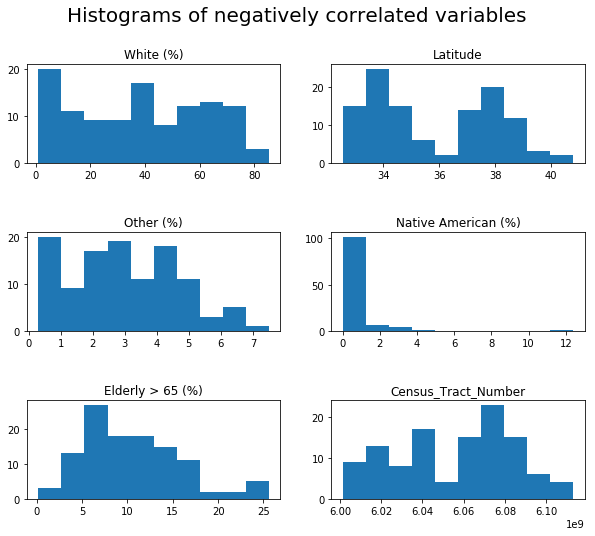

In [18]:
# Exploring distributions of negatively correlated variables via histograms
# Only 'Native American (%)' is strongly positively skewed
fig = plt.figure(figsize=(10, 8))
plt.suptitle('Histograms of negatively correlated variables', size=20)
colnames_neg = neg.index[:6]
corels_neg = np.round(neg[:6],2)
for k in range(6):
    fig.add_subplot(3,2,k+1)
    plt.hist(gdf[colnames_neg[k]])
    plt.title('{}'.format(colnames_neg[k]))
fig.subplots_adjust(hspace = 0.7)
plt.show()

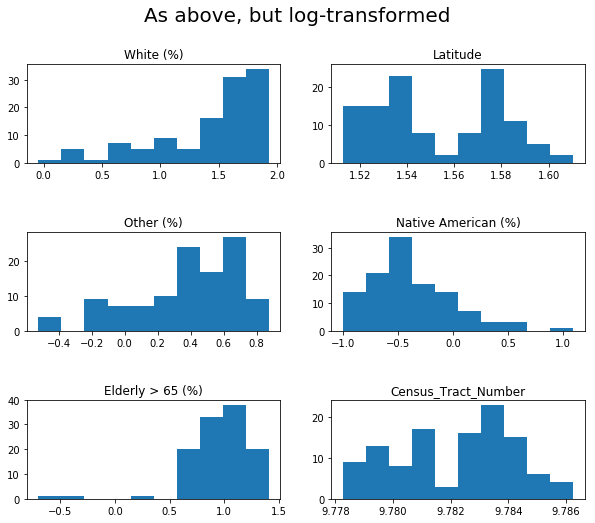

In [19]:
# Applying a log-transformation to see how the distributions change

# Handling few zero values in 'Native American (%)'--> setting to 0.1

gdf['Native American (%)'][75] = 0.1
gdf['Native American (%)'][94] = 0.1
gdf['Native American (%)'][104] = 0.1

fig = plt.figure(figsize=(10, 8))
plt.suptitle('As above, but log-transformed', size=20)
colnames_neg = neg.index[:6]
corels_neg = np.round(neg[:6],2)
for k in range(6):
    fig.add_subplot(3,2,k+1)
    plt.hist(np.log10(gdf[colnames_neg[k]]))
    plt.title('{}'.format(colnames_neg[k]))
fig.subplots_adjust(hspace = 0.7)
plt.show()

# The 'Native American (%)' predictor variable is now closer to normal distribution

# 9. Building a Multiple Linear Regression (OLS) Model

In [20]:
# Multiple linear regression using all predictor variables
# Still an OLS model to start, e.g. non-spatial --> not taking spatial autocorrelation into account

# Making sure 'predict_df' doesn't already exist, or it will mess up concatenation in steps following
varnames = globals().keys()
if 'predict_df' in varnames:
    del predict_df 
else:
    pass

# Building a predictor dataframe --> first, appending variables which don't need transforming
predict_df = pd.concat([gdf['PM2.5'],gdf['Hispanic (%)'],gdf['Low Birth Weight']], axis=1)
predict_df = pd.concat([predict_df,gdf['Ozone'],gdf['Poverty'],gdf['Housing Burden']], axis=1)
predict_df = pd.concat([predict_df,gdf['Cardiovascular Disease'],gdf['Drinking Water Contam. Index']], axis=1)
predict_df = pd.concat([predict_df,gdf['White (%)'],gdf['Latitude'],gdf['Other (%)']], axis=1)
predict_df = pd.concat([predict_df,gdf['Elderly > 65 (%)'],gdf['Census_Tract_Number']], axis=1)

# Next, log-transforming and appending predictor variables with high skewness
predict_df = pd.concat([predict_df,np.log10(gdf['Tox. Release']),np.log10(gdf['Diesel PM'])], axis=1)
predict_df = pd.concat([predict_df,np.log10(gdf['Traffic']),np.log10(gdf['Low Education'])], axis=1)
predict_df = pd.concat([predict_df,np.log10(gdf['Linguistic Isolation']),np.log10(gdf['African American (%)'])], axis=1)
predict_df = pd.concat([predict_df,np.log10(gdf['Asian American (%)']),np.log10(gdf['Asthma'])], axis=1)
predict_df = pd.concat([predict_df,np.log10(gdf['Native American (%)'])], axis=1)

# Setting the independent and dependent variables
X = predict_df.reset_index(drop=True)
y = gdf['no2 (ppb)'].reset_index(drop=True)

# Creating a 70-30 train/test split, with random seed set for replication
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# We have 114 observations (sites), and 22 predictor variables

(79, 22) (79,)
(35, 22) (35,)


In [21]:
# Fitting the model on the training data

# I like using 'statsmodels' for this since it prints a nice summary of model coefficients
# I haven't found a way to do this using sklearn 'linear_model' module
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              no2 (ppb)   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              38.86
Date:                Tue, 26 Nov 2019   Prob (F-statistic):                    1.42e-26
Time:                        18:10:31   Log-Likelihood:                         -208.91
No. Observations:                  79   AIC:                                      461.8
Df Residuals:                      57   BIC:                                      513.9
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
PM2.5                           -0.2765      0.262     -1.057      0.295      -0.801       0.247
Hispanic (%)                    -0.1112      0.079     -1.414      0.163      -0.269       0.046
Low Birth Weight                 0.0938      0.534      0.176      0.861      -0.975       1.162
Ozone                          158.8627     78.991      2.011      0.049       0.686     317.039
Poverty                          0.0087      0.049      0.176      0.861      -0.090       0.108
Housing Burden                   0.0205      0.110      0.187      0.853      -0.200       0.241
Cardiovascular Disease           0.0260      0.233      0.112      0.912      -0.441       0.493
Drinking Water Contam. Index     0.0009      0.003      0.316      0.753      -0.005       0.007
White (%)                       -0.1030      0.075     -1.379      0.173      -0.253       0.047
Latitude                        -0.4507      0.300     -1.504      0.138      -1.051       0.149
Other (%)                       -0.1654      0.646     -0.256      0.799      -1.458       1.127
Elderly > 65 (%)                 0.0079      0.130      0.061      0.952      -0.252       0.268
Census_Tract_Number           9.271e-10   2.86e-09      0.324      0.747    -4.8e-09    6.66e-09
Tox. Release                     1.0885      0.518      2.100      0.040       0.051       2.126
Diesel PM                        5.3830      1.743      3.089      0.003       1.893       8.873
Traffic                          5.4228      1.782      3.044      0.004       1.855       8.990
Low Education                    1.8141      2.453      0.740      0.463      -3.097       6.726
Linguistic Isolation            -0.3074      1.529     -0.201      0.841      -3.370       2.755
African American (%)            -1.3574      1.719     -0.790      0.433      -4.800       2.085
Asian American (%)              -2.5838      2.246     -1.150      0.255      -7.081       1.914
Asthma                           0.5450      3.405      0.160      0.873      -6.273       7.363
Native American (%)             -2.0050      1.681     -1.193      0.238      -5.372       1.362
==============================================================================
Omnibus:                        3.403   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                2.619
Skew:                           0.378   Prob(JB):                        0.270
Kurtosis:                       3.472   Cond. No.                     1.06e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is cor

In [154]:
# Checking for multicollinearity via the variance inflation factor (VIF)
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [soi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # using 'statsmodels'
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Feature,VIF
12,Census_Tract_Number,1173.772108
9,Latitude,546.906615
20,Asthma,190.390553
15,Traffic,112.821048
1,Hispanic (%),74.873535
3,Ozone,62.818082
8,White (%),56.738291
16,Low Education,42.156168
2,Low Birth Weight,32.091509
0,PM2.5,31.499149


- Adjusted R-squared is 0.913, but I have lots of multicollinearity here. Very high VIF's for many predictors - only a few of the predictor variables fall below a VIF value of 10, which is a generous cutoff for this metric to begin with.

- So, this model needs some serious pruning!

- There are 4 predictor variables with p-values < 0.05 in this model:
    - Ozone
    - Tox. Release
    - Diesel PM
    - Traffic

- I will retain Ozone, Tox. Release, and Diesel PM. I initially retained Traffic but I found it to be highly correlated with at least some of the other variables, so it was dropped. Instead, I retained White % since it had been the strongest negatively correlated variable to NO2 in the pair-wise relationships. 

# 10. Refining the OLS Model

In [22]:
# Subsetting the predictors and building a more parsimonious model

# Making sure 'predict_df' doesn't already exist, or it will mess up concatenation in steps following
varnames = globals().keys()
if 'predict_df' in varnames:
    del predict_df 
else:
    pass

# Choosing 4 predictor variables
predict_df = pd.concat([np.log10(gdf['Tox. Release']),np.log10(gdf['Diesel PM'])], axis=1)
predict_df = pd.concat([predict_df,gdf['Ozone'],gdf['White (%)']], axis=1)
predict_df = predict_df.reset_index(drop=True)

# Setting the independent and dependent variables
X = predict_df.reset_index(drop=True)
y = gdf['no2 (ppb)'].reset_index(drop=True)

# Creating a 70-30 train/test split, with random seed set for replication
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)

# Fitting the model on the training data
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              no2 (ppb)   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              189.3
Date:                Tue, 26 Nov 2019   Prob (F-statistic):                    2.23e-38
Time:                        18:11:08   Log-Likelihood:                         -223.35
No. Observations:                  79   AIC:                                      454.7
Df Residuals:                      75   BIC:                                      464.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Tox. Release     1.1373      0.435      2.613      0.011       0.270       2.004
Diesel PM        5.3661      1.128      4.757      0.000       3.119       7.613
Ozone          113.7171     30.027      3.787      0.000      53.900     173.534
White (%)       -0.0479      0.019     -2.465      0.016      -0.087      -0.009
==============================================================================
Omnibus:                        9.879   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.731
Skew:                           0.761   Prob(JB):                      0.00771
Kurtosis:                       3.798   Cond. No.                     2.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# Checking for multicollinearity via the variance inflation factor (VIF)
# For smaller model
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [soi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # using 'statsmodels'
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Feature,VIF
2,Ozone,9.101101
1,Diesel PM,8.933273
0,Tox. Release,5.564140
3,White (%),3.127980


- A much better model. Adjusted R-squared dropped slightly to 0.905, but I now have a parsimonious model with only 4 predictor variables compared with 22. All 4 predictors are statistically significant in the model (p-value < 0.05), and VIF's are acceptable as all values are below 10. 

- More importantly, this mix of predictors makes intuitive sense for NO2 concentration. Diesel emissions are an important source of NO2 pollution for example, and areas with a high proportion of white residents have consistently over time been shown to correlate with better environmental indicators in the US.

# 11. Predicting NO2 Using the Refined Model

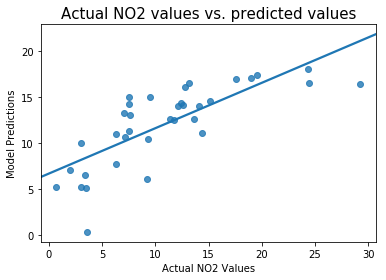

In [24]:
# Predicting the holdout sample of 35 sites
# Using the refined model with 4 predictor variables
predictions = model.predict(X_test) 

# Visualizing model performance with a regression plot
predictions = pd.DataFrame(predictions)
y_test = pd.DataFrame(y_test)
data = pd.concat([predictions,y_test], axis=1).reset_index(drop=True)
data = data.rename(columns={0:'Model Predictions', 'no2 (ppb)':'Actual NO2 Values'})
sns.regplot(data['Actual NO2 Values'], data['Model Predictions'], ci=None)
plt.title('Actual NO2 values vs. predicted values', size=15)
plt.show()

# 12. Model Diagnostics

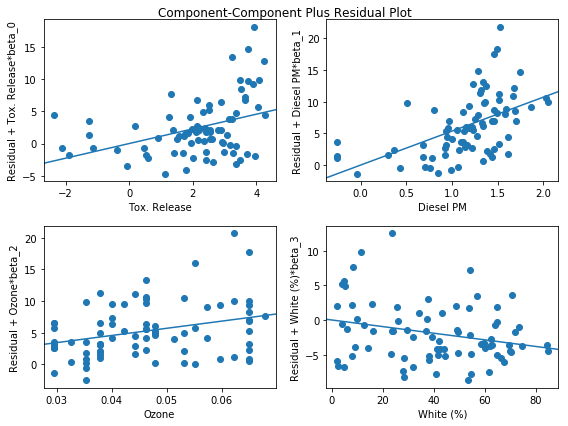

In [41]:
# Checking distributions of residuals of predictor variables,
# taking into account that the 4 independent variables are in model together

# Using 'statsmodels' CCPR plots with my model data
fig = plt.figure(figsize=(8,6))
rp.plot_ccpr_grid(model, fig=fig)   
plt.show()

- Residual plots for the predictor variables look fairly good for Ozone and White %, with variance of residuals mostly stable through the range of predictor values. Not looking as good for Tox. Release and Diesel PM, with variance in residuals not stable. A linear model may not be the best fit for those predictor variables. 

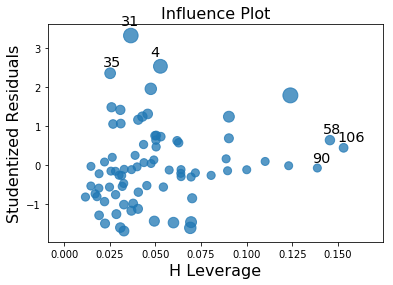

In [48]:
# Making influence plot for each of the 79 training sites in model
# Sites are labeled by original index numbers in the 114-site dataframe before split

p = soi.OLSInfluence(model) # using 'statsmodels'
p.plot_influence(size=15)
plt.show()

- The influence plot shows that several of the NO2 sites have an outsized influence on the regression line in my model. For example, sites (4,31,35) have large positive residuals. Sites (58,90,106) have high leverage/hat value. Both of these metrics indicate a poor fit for those locations in my model.

- It would be interesting to explore these sites in more detail and understand why they behave differently compared to the other sites in the training set, and what insights can be learned that will help NO2 modeling more generally. 

# 13. Conclusion

- Census tracts with 1) high levels of ozone, 2) high diesel emissions, 3) chemical releases from facility emissions (Tox. Release), and 4) high minority % (e.g. low white percentage) are especially vulnerable to elevated levels of NO2 pollution in California. These results can be framed within the context of environmental justice and known patterns of socioeconomic vulnerability, as environmental hazards have repeatedly been shown to concentrate in areas of low socioeconomic status in many areas of the world. 

# 14. Next Steps - Future Modeling Efforts

- The next step, in my opinion, would be to run a spatial model with geographic weights explicitly specified. There is clearly spatial autocorrelation in the NO2 data as we saw in the high values around Los Angeles and San Francisco, for example. The OLS model I built does not take this spatial autocorrelation into account. Options that I'm aware of include a Spatial Error Model, Spatial Lag Model, Geographically Weighted Regression, Spatial Durbin Model, etc. I have experience with all of these modeling approaches using R, but should be able to quickly learn how to do them in Python as well. For instance, I've been meaning to use 'PySAL' and this would be a good application for that package. 

- Staying on the purely spatial side, it would be interesting to run a classic ML algorithm such as Random Forest on the data. There's a good chance we would see a bump in predictive power while still maintaining explainability through variable importance checking, reverse feature elimination, etc. in addition to explicitly engineering features based on domain knowledge. I could also explore neural network approaches if even more predictive power is desired, but we would trade off explainability in this case.

- Another interesting application would be to run a convolutional neural network (CNN) on image data of remotely sensed NO2 pollution (assuming this measurement capability exists for NO2?). I have seen an application of this for air quality in Texas, I belive it was for PM2.5 and ozone. I attended a seminar last summer at JPL on this subject, given by a visiting professor from the University of Houston: (Yunsoo Choi, https://www.researchgate.net/profile/Yunsoo_Choi) 

- Finally, a hierarchical/Bayesian model could be implemented which takes into account both the spatial and temporal dimensions of NO2 data. For the temporal element, I would be very interested in looking at weather data for explanatory ability. While I don't have experience with hierarchical modeling, I would be glad to learn this modeling approach and apply it to air quality data. 